### MSDS 5510 - Unsupervised Learning
#### Description of Final project

The capstone project of this course is to provide a notebook that demonstrates successful deployment of an unsupervised learning method for a real world problem.
For my submission, I will evaluate Principle Component Analysis (PCA henceforth) as a dimensionality reduction technique for algorithmic trading.

The motivation for utilizing dimensionality reduction in an algorithmic trading strategy is to
minimize sparsity of input data. Investing strategies leverage large datasets with a multitude of features which potentially are detrimental to model generalization.
Furthermore, some model features simply may not be conducive to profitable strategies. Lastly, this point is speculative and will be evaluated in this notebook, investigation will be  performed to assess strength of PCA components as a predictive signal.

In this notebook, I will perform the following tasks to develop and use such a model:
- Procure data and describe base features
- Perform feature engineering to clean data and develop new features for model
- Implement a PCA model to reduce the input features to a manageable figure
- Implement a NMF model to reduce input features
- Evaluate Trading strategy with the following inputs:
    1. Base features
    2. PCA compressed features
    3. NMF compressed features
- A discussion will be made to evaluate the trading strategies for various input datasets

DISCLAIMER: Given that this assignment is intended to evaluate students' understanding of unsupervised learning algorithms, specific focus will be
made to demonstrate aptitude of unsupervised models. The development of feature engineering and trading strategies are essential to the analysis in this notebook, but NOT
a consideration of the grading rubric. As with any financial model, the insights are strictly experimental and should not be considered financial advise.

#### Import Libraries

In [1]:
# It is assumed that the libraries are installed locally, however pip install instructions are included below and github addresses are available
# !pip install ccxt
# !pip install git+https://github.com/bukosabino/ta.git
# !pip install git+https://github.com/bashtage/arch.git

import ccxt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
import copy
import pickle
import random
import os
import ta as ta
from arch import arch_model
from sklearn.preprocessing import StandardScaler as scaler
scaler = scaler()
from numpy.ma.core import mean


from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split


#### Notes on input Data

For this project we will be using time series data for Ethereum cryptocurrency. The data will be queried from the FTX exchange via the CCXT library in python. Base data features are: 'open', 'high', 'low', 'close', 'volume' as well as datetime as an index value.

Ethereum, as with all cryptocurrencies, trades continuously without any breaks. The specific time series we will be extracting for analysis and model construction is discrete 60 minute data.
Data features will be constructed with typical technical analysis approaches and will be achieved with the TA library in Python.

Data cleaning and EDA will be performed in the following section.

In [2]:
ftx = ccxt.ftx({})
ftx.load_markets()
ftx.verbose = True

In [89]:
# Get Data
def getData(symbol, denominator, duration):
  ticker = symbol+'/' + denominator
  data = ftx.fetch_ohlcv(ticker, timeframe=duration, since=None, limit=None, params={})
  # Put in to dataframe, clean up.
  data = pd.DataFrame(data, columns=['time','open','high','low','close','volume'])
  data['time'] = pd.to_datetime(data['time'], unit='ms')
  data.set_index('time', inplace=True)
  AllData = data
  return AllData

# Garch model for asset volatility projections
def garch_stuff(df):
    estRange = 125 # 100
    projection = 1
    scaler = 1000
    df["GarVar"] = np.nan
    rets = AllData.close.pct_change(1)
    for steps in range(estRange+1, rets.shape[0]):
        model = arch_model(scaler * np.array(rets[steps - estRange:steps]), mean='Zero', vol='GARCH', p=1, q=1)
        model_fit = model.fit()
        yhat = model_fit.forecast(horizon=projection)
        pred = (yhat.variance.values[-1, :] / scaler)
        df['GarVar'].iloc[steps] = pred[0]
    return df

# Acquire all technical data points, normalize
def makeTechnicalFeatures(AllData):
  #Create Features for training
  try:
      # RSI
      rsi14 = ta.momentum.RSIIndicator(close=AllData['close'], window=14, fillna=True)
      AllData['rsi14'] = rsi14.rsi()
      AllData['rsi14'] = scaler.fit_transform(AllData[["rsi14"]])
      rsi9 = ta.momentum.RSIIndicator(close=AllData['close'], window=9, fillna=True)
      AllData['rsi9'] = rsi9.rsi()
      AllData['rsi9'] = scaler.fit_transform(AllData[["rsi9"]])
      # MACD 5, 35, 5
      macd5355 = ta.trend.MACD(close=AllData['close'], window_slow=35, window_fast=5, window_sign=5, fillna=True)
      AllData['MACD5355macddiff'] = macd5355.macd_diff()
      AllData['MACD5355macddiffslope'] = macd5355.macd_diff().diff() # Slope of line
      AllData['MACD5355macddiff'][AllData['MACD5355macddiff'] >= 0] = 1
      AllData['MACD5355macddiff'][AllData['MACD5355macddiff'] < 0] = 0
      AllData['MACD5355macddiffslope'][AllData['MACD5355macddiffslope'] >= 0] = 1
      AllData['MACD5355macddiffslope'][AllData['MACD5355macddiffslope'] < 0] = 0

      AllData['MACD5355macd'] = macd5355.macd()
      AllData['MACD5355macdslope'] = macd5355.macd().diff()
      AllData['MACD5355macd'][AllData['MACD5355macd'] >= 0] = 1
      AllData['MACD5355macd'][AllData['MACD5355macd'] < 0] = 0
      AllData['MACD5355macdslope'][AllData['MACD5355macdslope'] >= 0] = 1
      AllData['MACD5355macdslope'][AllData['MACD5355macdslope'] < 0] = 0

      AllData['MACD5355macdsig'] = macd5355.macd_signal()
      AllData['MACD5355macdsigslope'] = macd5355.macd_signal().diff()
      AllData['MACD5355macdsig'][AllData['MACD5355macdsig'] >= 0] = 1
      AllData['MACD5355macdsig'][AllData['MACD5355macdsig'] < 0] = 0
      AllData['MACD5355macdsigslope'][AllData['MACD5355macdsigslope'] >= 0] = 1
      AllData['MACD5355macdsigslope'][AllData['MACD5355macdsigslope'] < 0] = 0
      # MACD 12,26,9
      macd12269 = ta.trend.MACD(close=AllData['close'], window_slow=26, window_fast=12, window_sign=9, fillna=True)
      AllData['MACD12269macddiff'] = macd12269.macd_diff()
      AllData['MACD12269macddiffslope'] = macd12269.macd_diff().diff() # Slope of line
      AllData['MACD12269macddiff'][AllData['MACD12269macddiff'] >= 0] = 1
      AllData['MACD12269macddiff'][AllData['MACD12269macddiff'] < 0] = 0
      AllData['MACD12269macddiffslope'][AllData['MACD12269macddiffslope'] >= 0] = 1
      AllData['MACD12269macddiffslope'][AllData['MACD12269macddiffslope'] < 0] = 0

      AllData['MACD12269macd'] = macd12269.macd()
      AllData['MACD12269macdslope'] = macd12269.macd().diff()
      AllData['MACD12269macd'][AllData['MACD12269macd'] >= 0] = 1
      AllData['MACD12269macd'][AllData['MACD12269macd'] < 0] = 0
      AllData['MACD12269macdslope'][AllData['MACD12269macdslope'] >= 0] = 1
      AllData['MACD12269macdslope'][AllData['MACD12269macdslope'] < 0] = 0

      AllData['MACD12269macdsig'] = macd12269.macd_signal()
      AllData['MACD12269macdsigslope'] = macd12269.macd_signal().diff()
      AllData['MACD12269macdsig'][AllData['MACD12269macdsig'] >= 0] = 1
      AllData['MACD12269macdsig'][AllData['MACD12269macdsig'] < 0] = 0
      AllData['MACD12269macdsigslope'][AllData['MACD12269macdsigslope'] >= 0] = 1
      AllData['MACD12269macdsigslope'][AllData['MACD12269macdsigslope'] < 0] = 0

      # Engulfing Bars
      AllData['lowTail'] = AllData['low'].pct_change()
      AllData['lowTail'] = scaler.fit_transform(AllData[["lowTail"]])
      AllData['highTail'] = AllData['high'].pct_change()
      AllData['highTail'] = scaler.fit_transform(AllData[["highTail"]])
      AllData['openTail'] = AllData['open'].pct_change()
      AllData['openTail'] = scaler.fit_transform(AllData[["openTail"]])
      AllData['IntradayBar'] = (AllData.close.values[:] - AllData.open.values[:]) / AllData.open.values[:]
      AllData['IntradayBar'] = scaler.fit_transform(AllData[["IntradayBar"]])
      AllData['IntradayRange'] = (AllData.high.values[:] - AllData.low.values[:]) / AllData.low.values[:]
      AllData['IntradayRange'] = scaler.fit_transform(AllData[["IntradayRange"]])
      # SMA divergence
      for s in range(5, 10, 200):
          AllData['CloseOverSMA'+str(s)] = AllData['close'] / AllData['close'].rolling(window=s).mean()
          AllData['CloseOverSMA'+str(s)][AllData['CloseOverSMA'+str(s)] >= 1] = 1
          AllData['CloseOverSMA'+str(s)][AllData['CloseOverSMA'+str(s)] < 1] = 0
      # SMA Volume divergence
      for s in range(5, 10, 220):
          AllData['VolOverSMA'+str(s)] = AllData['volume'] / AllData['volume'].rolling(window=s).mean()
          AllData['VolOverSMA'+str(s)][AllData['VolOverSMA'+str(s)] >= 1] = 1
          AllData['VolOverSMA'+str(s)][AllData['VolOverSMA'+str(s)] < 1] = 0

      # Recent Performance
      AllData['Ret1day'] = AllData['close'].pct_change(1)
      AllData['Ret1day'] = scaler.fit_transform(AllData[["Ret1day"]])
      AllData['Ret5day'] = AllData['close'].pct_change(5)
      AllData['Ret5day'] = scaler.fit_transform(AllData[["Ret5day"]])
      AllData['Ret10day'] = AllData['close'].pct_change(10)
      AllData['Ret10day'] = scaler.fit_transform(AllData[["Ret10day"]])
      AllData['Ret22day'] = AllData['close'].pct_change(22)
      AllData['Ret22day'] = scaler.fit_transform(AllData[["Ret22day"]])
      AllData['Ret65day'] = AllData['close'].pct_change(65)
      AllData['Ret65day'] = scaler.fit_transform(AllData[["Ret65day"]])
      AllData['Ret252day'] = AllData['close'].pct_change(252)
      AllData['Ret252day'] = scaler.fit_transform(AllData[["Ret252day"]])

      # BBs
      BB = ta.volatility.BollingerBands(close=AllData['close'], fillna=True, window=30)
      AllData['bandsGap30'] = (AllData.close - BB.bollinger_lband()) / (BB.bollinger_hband() - BB.bollinger_lband())
      # Replace infs with last non-inf entry
      try:
          infs = AllData['bandsGap30'][np.isinf(AllData['bandsGap30']) == True].iloc
          for u in infs[:].index[:].values:
              AllData['bandsGap30'][u] = AllData['bandsGap30'][u-1]
      except:
          1
      AllData['bandsGap30'] = scaler.fit_transform(AllData[["bandsGap30"]])

      BB = ta.volatility.BollingerBands(close=AllData['close'], fillna=True, window=100)
      AllData['bandsGap100'] = (AllData.close - BB.bollinger_lband()) / (BB.bollinger_hband() - BB.bollinger_lband())
      # Replace infs with last non-inf entry
      try:
          infs = AllData['bandsGap100'][np.isinf(AllData['bandsGap100']) == True].iloc
          for u in infs[:].index[:].values:
              AllData['bandsGap100'][u] = AllData['bandsGap100'][u-1]
      except:
          1
      AllData['bandsGap100'] = scaler.fit_transform(AllData[["bandsGap100"]])

      BB = ta.volatility.BollingerBands(close=AllData['close'], fillna=True, window=200)
      AllData['bandsGap200'] = (AllData.close - BB.bollinger_lband()) / (BB.bollinger_hband() - BB.bollinger_lband())
      # Replace infs with last non-inf entry
      try:
          infs = AllData['bandsGap200'][np.isinf(AllData['bandsGap200']) == True].iloc
          for u in infs[:].index[:].values:
              AllData['bandsGap200'][u] = AllData['bandsGap200'][u-1]
      except:
          1
      AllData['bandsGap200'] = scaler.fit_transform(AllData[["bandsGap200"]])

      # ADX
      ADX = ta.trend.ADXIndicator(high=AllData['high'], low=AllData['low'], close=AllData['close'], window=14,
                                  fillna=True)
      AllData['ADX'] = ADX.adx()
      AllData['ADX'] = scaler.fit_transform(AllData[["ADX"]])

      # Ichimoku
      ICH = ta.trend.IchimokuIndicator(high=AllData['high'], low=AllData['low'], fillna=True)
      AllData['closeVsIchA'] = AllData['close'] / ICH.ichimoku_a()
      AllData['closeVsIchA'] = scaler.fit_transform(AllData[["closeVsIchA"]])
      AllData['closeVsIchB'] = AllData['close'] / ICH.ichimoku_b()
      AllData['closeVsIchB'] = scaler.fit_transform(AllData[["closeVsIchB"]])
      AllData['IchAvIchB'] = ICH.ichimoku_a() / ICH.ichimoku_b()
      AllData['IchAvIchB'] = scaler.fit_transform(AllData[["IchAvIchB"]])
      # Garch volatility forecast
      # AllData = garch_stuff(AllData)
      # AllData['GarVar'] = scaler.fit_transform(AllData[["GarVar"]])
      # # Vol Recent changes
      # AllData['VolRet1day'] = AllData['GarVar'].diff(1)
      # AllData['VolRet1day'] = scaler.fit_transform(AllData[["VolRet1day"]])
      # AllData['VolRet3day'] = AllData['GarVar'].diff(3)
      # AllData['VolRet3day'] = scaler.fit_transform(AllData[["VolRet3day"]])
      # AllData['VolRet5day'] = AllData['GarVar'].diff(5)
      # AllData['VolRet5day'] = scaler.fit_transform(AllData[["VolRet5day"]])
      # AllData['VolRet10day'] = AllData['GarVar'].diff(10)
      # AllData['VolRet10day'] = scaler.fit_transform(AllData[["VolRet10day"]])
      # Lows Recent changes
      AllData['LowsRet1day'] = AllData['low'].diff(1)
      AllData['LowsRet1day'] = scaler.fit_transform(AllData[["LowsRet1day"]])
      AllData['LowsRet3day'] = AllData['low'].diff(3)
      AllData['LowsRet3day'] = scaler.fit_transform(AllData[["LowsRet3day"]])
      AllData['LowsRet5day'] = AllData['low'].diff(5)
      AllData['LowsRet5day'] = scaler.fit_transform(AllData[["LowsRet5day"]])
      # Highs Recent changes
      AllData['HighsRet1day'] = AllData['high'].diff(1)
      AllData['HighsRet1day'] = scaler.fit_transform(AllData[["HighsRet1day"]])
      AllData['HighsRet3day'] = AllData['high'].diff(3)
      AllData['HighsRet3day'] = scaler.fit_transform(AllData[["HighsRet3day"]])
      AllData['HighsRet5day'] = AllData['high'].diff(5)
      AllData['HighsRet5day'] = scaler.fit_transform(AllData[["HighsRet5day"]])
      # Volume by Price (+/-) 2.5% in the last 60 periods
      bins = 10
      binRange = .05
      duration = 4*24
      # holding array
      binnedData = np.zeros((AllData.__len__(), bins))
      for t in range(duration, AllData.__len__()):
          # Determine Price Range
          priceRange = np.linspace(AllData.close.values[t] * (1 - binRange), AllData.close.values[t] * (1 + binRange), bins)
          for j in range(1, len(priceRange)):
              binnedData[t, j] = sum(AllData['volume'][t - duration:t][(AllData.close[t - duration:t] <= priceRange[j]) &
                                                                    (AllData.close[t - duration:t] >= priceRange[
                                                                        j - 1])])
          binnedData[t, :] = binnedData[t, :] / binnedData[t, :].max()
      for j in range(1, bins):
          AllData['bin' + str(j)] = binnedData[:, j]

      # for c in AllData.columns:
      #   if c != 'close':  # Add others (i.e open, high low, etc):
      #     AllData[c+'shift1'] = A[c]/A[c].shift(1)

      # Clean up output
      InputData = AllData[-100:]
      AllData = AllData.dropna(axis=0, how='any')

      return AllData, InputData

  except:
      1


# Classification

def SpitOutWasUp(df, periods, oos_length, train_proportion):
  Length = np.shape(df.close)
  WasUp = np.nan * (np.zeros(Length))
  WasUp[:-periods] = df.close.values[periods:]/df.open.values[1:Length[0] - periods + 1]
  df['WasUp'] = WasUp - 1
  df['Target'] = df['WasUp'].values
  for J in range(len(df)):
      if df['WasUp'].values[J] >= 0:
          df['Target'].values[J] = 1  # Positive Ret
      elif df['WasUp'].values[J] < 0:
          df['Target'].values[J] = 0  # Negative Ret

  df = df.dropna(axis=0)
  oos_data = df[-oos_length:]
  data = df[:-oos_length]

  # Test, Train & oos data
  X = data.drop(['open', 'high', 'low', 'close', 'volume', 'WasUp', 'Target'], axis=1)
  y = data.Target
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1 - train_proportion, random_state = 42, stratify = y)

  oos_X = oos_data.drop(['open', 'high', 'low', 'close', 'volume', 'WasUp', 'Target'], axis=1)
  oos_y_target = oos_data.Target
  oos_y_WasUp = oos_data.WasUp
  oos_close = oos_data.close

  # cur_oos_X = InputData.drop(['open', 'high', 'low', 'close', 'volume', 'WasUp', 'Target'], axis=1)
  # cur_oos_close = oos_data.close

  return X_train, X_test, y_train, y_test, oos_X, oos_y_target, oos_y_WasUp, oos_close


fetch Request: ftx GET https://ftx.com/api/markets/ETH/USD/candles?resolution=3600&limit=1500 RequestHeaders: {'User-Agent': 'python-requests/2.25.1', 'Accept-Encoding': 'gzip, deflate', 'Accept': '*/*', 'Connection': 'keep-alive'} RequestBody: None

fetch Response: ftx GET https://ftx.com/api/markets/ETH/USD/candles?resolution=3600&limit=1500 200 ResponseHeaders: {'Date': 'Tue, 14 Jun 2022 20:55:48 GMT', 'Content-Type': 'application/json', 'Transfer-Encoding': 'chunked', 'Connection': 'keep-alive', 'Vary': 'Accept-Encoding, Accept-Encoding, Origin', 'Cache-Control': 'public, max-age=60', 'ETag': 'W/"4e9b9df1d1330503c0835577a2d67cf9"', 'Content-Encoding': 'gzip', 'Strict-Transport-Security': 'max-age=31536000; includeSubDomains; preload', 'X-Frame-Options': 'sameorigin', 'X-Content-Type-Options': 'nosniff', 'X-XSS-Protection': '1; mode=block', 'Content-Security-Policy': 'block-all-mixed-content', 'X-Cache-Status': 'MISS', 'CF-Cache-Status': 'EXPIRED', 'Expect-CT': 'max-age=604800, rep

(array([19097., 19104., 19113., 19120., 19127., 19134., 19144., 19151.,
        19158.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

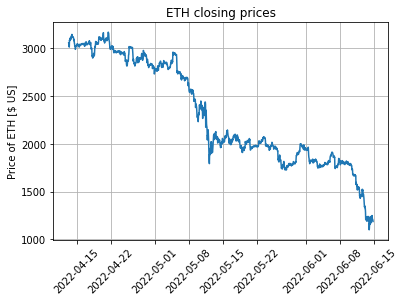

In [90]:
AllData = getData('ETH','USD', '1h')
print(AllData.head(10))

plt.plot(AllData.close)
plt.title('ETH closing prices')
plt.ylabel('Price of ETH [$ US]')
plt.grid()
plt.xticks(rotation=45)

In [91]:
AllData, InputData = makeTechnicalFeatures(AllData)
print(AllData.head(10))

c:\users\jefferya\pycharmprojects\pythonproject\venv\lib\site-packages\ta\trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
c:\users\jefferya\pycharmprojects\pythonproject\venv\lib\site-packages\ta\trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
<ipython-input-89-7a5cb5fc0bae>:206: RuntimeWarning: invalid value encountered in true_divide
  binnedData[t, :] = binnedData[t, :] / binnedData[t, :].max()
<ipython-input-89-7a5cb5fc0bae>:206: RuntimeWarning: invalid value encountered in true_divide
  binnedData[t, :] = binnedData[t, :] / binnedData[t, :].max()
<ipython-input-89-7a5cb5fc0bae>:206: RuntimeWarning: invalid value encountered in true_divide
  binnedData[t, :] = binnedData[t, :] / binnedData[t, :].max()


                       open    high     low   close        volume     rsi14  \
time                                                                          
2022-04-23 21:00:00  2964.1  2970.7  2961.6  2967.8  3.613442e+06  0.338249   
2022-04-23 22:00:00  2967.8  2969.5  2954.3  2956.0  3.933827e+06 -0.163023   
2022-04-23 23:00:00  2956.0  2956.0  2922.5  2933.2  8.282797e+06 -0.892149   
2022-04-24 00:00:00  2933.2  2946.0  2931.8  2935.7  7.116176e+06 -0.771116   
2022-04-24 01:00:00  2935.7  2943.0  2928.2  2928.2  5.554366e+06 -0.980822   
2022-04-24 02:00:00  2928.2  2939.5  2922.6  2933.0  4.552769e+06 -0.737779   
2022-04-24 03:00:00  2933.0  2960.8  2930.6  2956.7  1.181098e+07  0.251348   
2022-04-24 04:00:00  2956.7  2959.9  2949.8  2952.0  3.258424e+06  0.089429   
2022-04-24 05:00:00  2952.0  2953.9  2945.0  2945.0  3.207570e+06 -0.144579   
2022-04-24 06:00:00  2945.0  2959.2  2944.3  2952.7  3.449849e+06  0.152774   

                         rsi9  MACD5355macddiff  MA

In [92]:
# All feature names:
print(AllData.columns)

Index(['open', 'high', 'low', 'close', 'volume', 'rsi14', 'rsi9',
       'MACD5355macddiff', 'MACD5355macddiffslope', 'MACD5355macd',
       'MACD5355macdslope', 'MACD5355macdsig', 'MACD5355macdsigslope',
       'MACD12269macddiff', 'MACD12269macddiffslope', 'MACD12269macd',
       'MACD12269macdslope', 'MACD12269macdsig', 'MACD12269macdsigslope',
       'lowTail', 'highTail', 'openTail', 'IntradayBar', 'IntradayRange',
       'CloseOverSMA5', 'VolOverSMA5', 'Ret1day', 'Ret5day', 'Ret10day',
       'Ret22day', 'Ret65day', 'Ret252day', 'bandsGap30', 'bandsGap100',
       'bandsGap200', 'ADX', 'closeVsIchA', 'closeVsIchB', 'IchAvIchB',
       'LowsRet1day', 'LowsRet3day', 'LowsRet5day', 'HighsRet1day',
       'HighsRet3day', 'HighsRet5day', 'bin1', 'bin2', 'bin3', 'bin4', 'bin5',
       'bin6', 'bin7', 'bin8', 'bin9'],
      dtype='object')


#### Notes on Technical features and handling
The technical analysis library takes input from the base features and performs transforms on the data. Because some of features have trailing and rolling averages
there are NaN values that must be imputed. Nan Values will be dropped from the data set entirely. There is also the specific need to scale values to a common range.
The Standard Scaler was selected to process large values (i.e. volume & price related features).
The decision was also made to compress certain signal values to a binary 0,1 value. For example, if the price of Ethereum was above the price level of the trailing 5 period a value of 1 will be assigned to 'CloseOverSMA5' whereas the value will be 0 otherwise. Similar binary features will be
used for Moving average Convergence & divergence ranges (i.e zero cross, slope changes, etc).

More extensive notes on technical features can be found at the following link:
https://github.com/mrjbq7/ta-lib#readme


Below are plots of several indicators prior to appropriate scaling.

Text(0.5, 1.0, 'MACD Signal Slope [binary]')

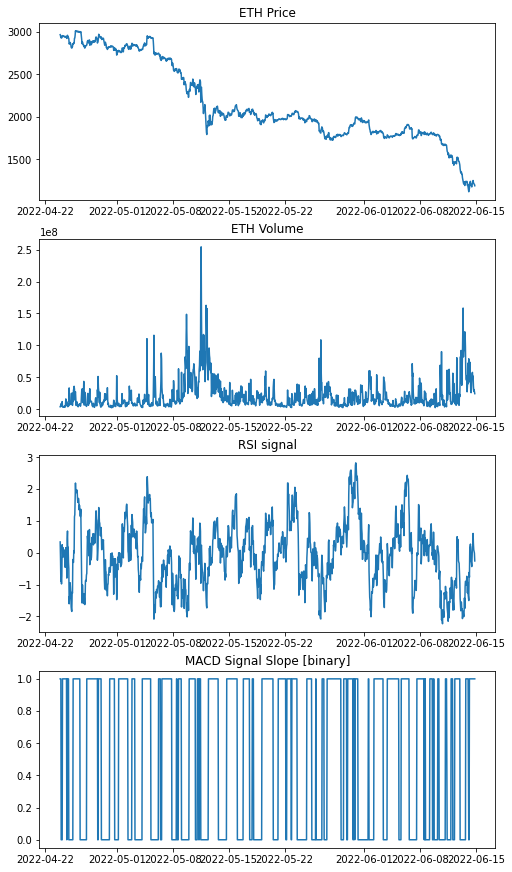

In [93]:
fig, axs = plt.subplots(4, 1, figsize=(7, 12), constrained_layout=True)
axs[0].plot(AllData.close)
axs[0].set_title('ETH Price')
axs[1].plot(AllData.volume)
axs[1].set_title('ETH Volume')
axs[2].plot(AllData.rsi14)
axs[2].set_title('RSI signal')
axs[3].plot(AllData.MACD12269macdsigslope)
axs[3].set_title('MACD Signal Slope [binary]')

Text(0.5, 1.0, 'Out of sample - RSI Scaled')

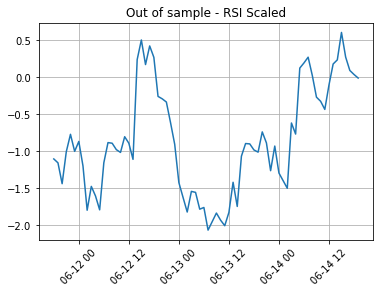

In [94]:
# Produce train/Test/Validation data
X_train, X_test, y_train, y_test, oos_X, oos_y_target, oos_y_WasUp, oos_close = SpitOutWasUp(AllData, 1, 72, .8)

plt.plot(oos_X.rsi14)
plt.xticks(rotation=45)
plt.grid()
plt.title('Out of sample - RSI Scaled')

#### Additional Notes on input data

The task that being addressed is predicting future values based on current signal data. If a position is to be taken in Ethereum we will either be Long or Short.
Therefore, we have a directional bias in our position. The problem of predicting price movements will be treated as a classification problem as opposed to a regression problem.

The closing price of ETH will be used to calculate the 1 period return of holding the currency.

$ ret(n) = (close(n+1) - close(n))/close(n) $

In this exercise, ret will be used as Y data for training and evaluating model performance.

#### PCA model and training

A PCA model will be trained using Scaled feature data from the X_train.

The input data has 54 features. We will seek to reduce the dimensionality to a smaller size. To decide a sufficient number of components we will use 90% of explained variance as the cut-off.
Below is a plot of # components vs. cumulative explained variance. We can see that at 12 components we have reached 90% total variance.
This is a 75.5% reduction of dimensions from the initial training data.

PCA reduced Data features by 75.51020408163265 %


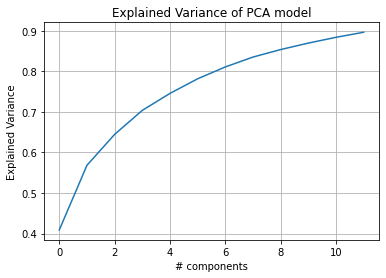

In [96]:
from sklearn.decomposition import PCA
model = PCA(n_components=20)
model.fit(X_train)
ExpVar = np.cumsum(model.explained_variance_ratio_)
comps = ExpVar[ExpVar <= 0.9]
plt.plot(ExpVar[:len(comps)])
plt.grid()
plt.title('Explained Variance of PCA model')
plt.xlabel('# components')
plt.ylabel('Explained Variance')


Reduction = 1-len(comps)/X_train.shape[1]
print('PCA reduced Data features by',100*Reduction,'%')

#### Comparison: Ethereum Closing prices vs. PCA components
The first 4 components will be printed as subplots and compared w/ the price
data of the Ethereum currency. Note the unique curves for each of the components.
Keep in mind that the 1st component consists of the most variance from the original dataset.
As component index increases, the related variance is smaller.

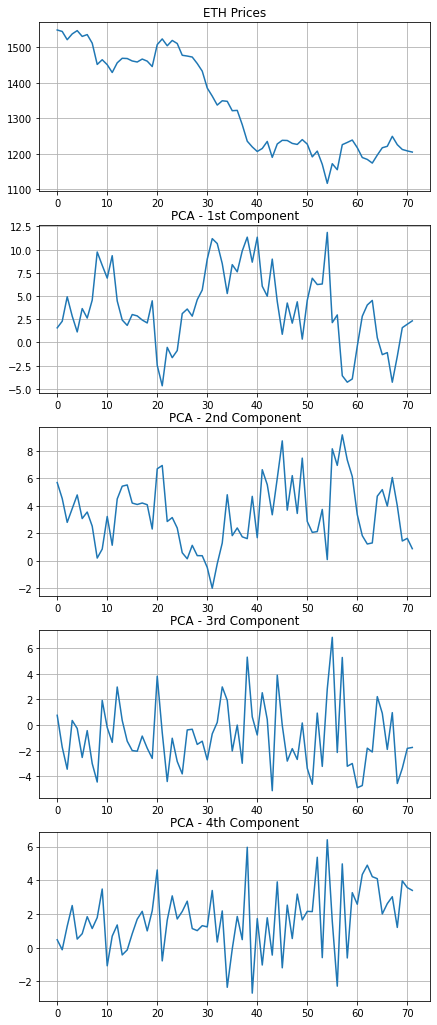

In [97]:
fig, axs = plt.subplots(5,1,figsize = (7,18))
comp_Xtest = model.transform(oos_X)

axs[0].plot(oos_close.values)
axs[0].set_title('ETH Prices')
axs[0].grid()

axs[1].plot(comp_Xtest[:,0])
axs[1].set_title('PCA - 1st Component')
axs[1].grid()

axs[2].plot(comp_Xtest[:,1])
axs[2].set_title('PCA - 2nd Component')
axs[2].grid()

axs[3].plot(comp_Xtest[:,2])
axs[3].set_title('PCA - 3rd Component')
axs[3].grid()

axs[4].plot(comp_Xtest[:,3])
axs[4].set_title('PCA - 4th Component')
axs[4].grid()





#### Trading model Construction:

This portion of this notebook is somewhat outside of the scope of this project but will be important for evaluating
the PCA features as a predictive signal for trading a cryptocurrency. I will briefly describe at a high level what is being
performed on the data. Readers with an interest in algorithmic trading may find value in scrutinizing the algorithms.

As previously mentioned, the Y data is a categorical variable representing whether the price went up or down over a period of time.
The trading strategy takes X data (either raw technical features or PCA compressed features)
and fits a support vector classifier model to the training data. Performance is based on model accuracy, that is predictive ability of
correctly stating a long or short position. Accuracy is provided for train, test and Out of sample validation data.
Since we are not interested in how well a model performs on historical data, we will focus on out of sample data accuracy.

An optimization function is also leveraged to tune hyperparameters of the model. These hyperparameters are C and gamma. Once the optimal
configuration of input variables is obtained, the out of sample performance will be plotted against
a control strategy that stictly holds the currency without taking short positions.


In [100]:
# Optimize Classification
def OptimizeModel(AllData, Periods, oos_prop, span, PCA_model, n_comps):
  Periods = int(Periods)
  parameters = {'gamma' : [1e-3,5e-2,1e-2,5e-1,1e-1,1,1.1,1.3,1.5],
                'C' : [.1,.2,.3,.4,.5,.6,.7,.8,.9,1,1.1,1.2,1.5,2,3,4,5,6,7,8,9,10,20,30]}
  X_train, X_test, y_train, y_test, oos_X, oos_y_target, oos_y_WasUp, oos_close = SpitOutWasUp(AllData, Periods, 72, oos_prop)

  from sklearn.preprocessing import MinMaxScaler
  sc_X = MinMaxScaler()

  if PCA_model != None:
      X_train = PCA_model.transform(X_train)
      X_train = sc_X.fit_transform(X_train[:,:n_comps])
      X_test = PCA_model.transform(X_test)
      X_test = sc_X.fit_transform(X_test[:,:n_comps])
      oos_X = PCA_model.transform(oos_X)
      oos_X = sc_X.fit_transform(oos_X[:,:n_comps])
  else:
      X_train = sc_X.fit_transform(X_train)
      X_test = sc_X.fit_transform(X_test)
      oos_X = sc_X.fit_transform(oos_X)

  nlsvm = SVC(kernel='rbf',random_state=42)
  # from xgboost import XGBClassifier as XGB
  # nlsvm = XGB()
  grid = GridSearchCV(nlsvm, parameters, cv = 5)
  grid.fit(X_train, y_train)
  # print(grid.best_params_)
  model = SVC(kernel='rbf', C=grid.best_params_['C'], gamma = grid.best_params_['gamma'], random_state=42, probability=True)
  model.fit(X_train, y_train)

  # Train Acc
  preds = model.predict(X_train)
  trainacc = accuracy_score(y_train, preds)
  # Test Acc
  preds = model.predict(X_test)
  testacc = accuracy_score(y_test, preds)
  # OOS Acc
  preds_oos = model.predict(oos_X)
  acc_oos = accuracy_score(oos_y_target, preds_oos)
  # OOS Preds
  predProb = model.predict_proba(oos_X)
  predProb = predProb[:, 1]

  span = span
  for i in range(len(oos_y_WasUp)):
    if predProb[i] < .5 - span:
      oos_y_WasUp[i] = -oos_y_WasUp[i]
    elif predProb[i] >= .5 + span:
      oos_y_WasUp[i] = oos_y_WasUp[i]
    else:
      oos_y_WasUp[i] = 0

  d = {'TrainAccuracy': [trainacc],
       'testacc': [testacc],
       'OOSAccuracy': [acc_oos],
       'TotalRets': [sum(oos_y_WasUp/Periods)],
       'PercLong': [len(predProb[predProb>.5])/len(predProb)],
       'AvgLong': [mean(oos_y_WasUp[predProb>.5])],
       'StdLong': [np.std(oos_y_WasUp[predProb>.5])],
       'AvgShort': [mean(oos_y_WasUp[predProb <=.5])],
       'StdShort': [np.std(oos_y_WasUp[predProb <=.5])],
       'C': [grid.best_params_['C']],
       'gamma': [grid.best_params_['gamma']],
       'periods': [Periods],
       'span': [span]}
  return d

# Plot the results of a model (Not with current data)

def Model_plot(AllData, Periods, oos_prop, span, C, gamma, PCA_model, n_comps):
  Periods = int(Periods)
  X_train, X_test, y_train, y_test, oos_X, oos_y_target, oos_y_WasUp, oos_close = SpitOutWasUp(AllData, Periods, 72, oos_prop)

  from sklearn.preprocessing import MinMaxScaler
  sc_X = MinMaxScaler()
  if PCA_model != None:
      X_train = PCA_model.transform(X_train)
      X_train = sc_X.fit_transform(X_train[:,:n_comps])
      X_test = PCA_model.transform(X_test)
      X_test = sc_X.fit_transform(X_test[:,:n_comps])
      oos_X = PCA_model.transform(oos_X)
      oos_X = sc_X.fit_transform(oos_X[:,:n_comps])
  else:
      X_train = sc_X.fit_transform(X_train)
      X_test = sc_X.fit_transform(X_test)
      oos_X = sc_X.fit_transform(oos_X)

  model = SVC(kernel='rbf', C=C, gamma=gamma, random_state=42, probability=True)
  model.fit(X_train, y_train)
  # from xgboost import XGBClassifier as XGB
  # model = XGB()
  # model.fit(X_train, y_train)
  # Train Acc
  preds = model.predict(X_train)
  trainacc = accuracy_score(y_train, preds)
  # Test Acc
  preds = model.predict(X_test)
  testacc = accuracy_score(y_test, preds)
  # OOS Acc
  preds_oos = model.predict(oos_X)
  acc_oos = accuracy_score(oos_y_target, preds_oos)
  # OOS Preds
  predProb = model.predict_proba(oos_X)
  predProb = predProb[:, 1]
  longOnly = copy.deepcopy(oos_y_WasUp)
  span = span
  for i in range(len(oos_y_WasUp)):
    if predProb[i] < .5 - span:
      oos_y_WasUp[i] = -oos_y_WasUp[i]
    elif predProb[i] >= .5 + span:
      oos_y_WasUp[i] = oos_y_WasUp[i]
    else:
      oos_y_WasUp[i] = 0

  d = {'TrainAccuracy': [trainacc],
       'testacc': [testacc],
       'OOSAccuracy': [acc_oos],
       'TotalRets': [sum(oos_y_WasUp/Periods)],
       'PercLong': [len(predProb[predProb>.5])/len(predProb)],
       'AvgLong': [np.mean(oos_y_WasUp[predProb>.5])],
       'StdLong': [np.std(oos_y_WasUp[predProb>.5])],
       'AvgShort': [np.mean(oos_y_WasUp[predProb <=.5])],
       'StdShort': [np.std(oos_y_WasUp[predProb <=.5])],
       'C': [C],
       'gamma': [gamma],
       'periods': [Periods],
       'span': [span]}

  derp = oos_y_WasUp[(predProb <=.5-span) | (predProb >=.5+span)]
  print(np.mean(derp),'average')
  print(np.std(derp),'std')
  print(np.mean(derp)/np.std(derp))

  fig,axs = plt.subplots(2,1,figsize=(7,9))
  axs[0].plot(oos_close.values)
  for i in range(len(oos_close)):
    if predProb[i] >= .5 + span:
      axs[0].scatter(i, oos_close.values[i]*0.9995,color='g',marker='^')
    elif predProb[i] < .5 - span:
      axs[0].scatter(i, oos_close.values[i]*1.0005, color='r',marker='v')
  axs[0].grid()
  axs[0].set_axis_off()
  # axs[0].set_xticklabels(oos_close.index, rotation=45)
  axs[0].set_title('ETH Entry Positions')

  axs[1].plot(np.cumsum(oos_y_WasUp/Periods),'-k')
  axs[1].plot(np.cumsum(longOnly),'--b')
  axs[1].grid()
  axs[1].legend(['Strategy','Long Only'])
  axs[1].set_title('Cumulative Returns')

  return d


#### Base features without PCA compression
The code below will run the optimization to find the best parameters
for a strategy consisting of the base 54 input parameters.

In [108]:
d1=OptimizeModel(AllData, Periods=1, oos_prop=.8, span=.0, PCA_model=None, n_comps=len(comps))

0.0011219038155571123 average
0.018623100517904778 std
0.06024259035054244
{'TrainAccuracy': [0.6755602988260405], 'testacc': [0.5148936170212766], 'OOSAccuracy': [0.5833333333333334], 'TotalRets': [0.08077707472011209], 'PercLong': [0.013888888888888888], 'AvgLong': [0.025826274705198493], 'StdLong': [0.0], 'AvgShort': [0.0007739549297875154], 'StdShort': [0.018519927999062002], 'C': [0.4], 'gamma': [0.5], 'periods': [1], 'span': [0.0]}


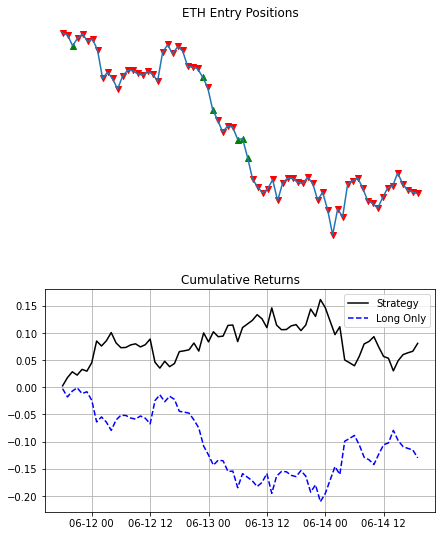

In [109]:
d = Model_plot(AllData,
           Periods = 1,
           oos_prop=.8,
           span= 0.0,
           C=d1['C'][0],
           gamma= d1['gamma'][0],
           PCA_model= None,
           n_comps= len(comps))
print(d)

#### Base features with PCA compression
The code below will run the optimization to find the best parameters for a strategy
 consisting of the first 3 principle components as input parameters.

In [126]:
d2=OptimizeModel(AllData, Periods=1, oos_prop=.8, span=.02, PCA_model=model, n_comps=3)#len(comps))

0.001802485229915152 average
0.01856958771936751 std
0.09706651850085048
{'TrainAccuracy': [0.5389541088580576], 'testacc': [0.5319148936170213], 'OOSAccuracy': [0.6388888888888888], 'TotalRets': [0.12977893655389094], 'PercLong': [0.0], 'AvgLong': [nan], 'StdLong': [nan], 'AvgShort': [0.001802485229915152], 'StdShort': [0.01856958771936751], 'C': [9], 'gamma': [1.3], 'periods': [1], 'span': [0.01]}


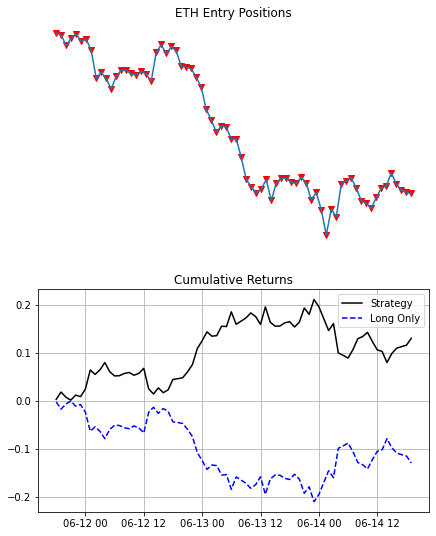

In [129]:
d = Model_plot(AllData,
           Periods = 1,
           oos_prop=.8,
           span= 0.01,
           C=d2['C'][0],
           gamma= d2['gamma'][0],
           PCA_model= model,
           n_comps= 3)#len(comps))
print(d)

#### Additional decomposition Method - NMF

After reviewing the performance of PCA, another decomposition method was chosen. NonZero Matrix Factorialization
will be used to assess SVM trading strategy w/ different feature compression. A total of five components will be used.

c:\users\jefferya\pycharmprojects\pythonproject\venv\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


72 72
{'TrainAccuracy': [0.5304162219850587], 'testacc': [0.5319148936170213], 'OOSAccuracy': [0.6111111111111112], 'TotalRets': [0.12977893655389094], 'PercLong': [0.0], 'AvgLong': [nan], 'StdLong': [nan], 'AvgShort': [0.001802485229915152], 'StdShort': [0.01856958771936751], 'C': [30], 'gamma': [0.1], 'periods': [1], 'span': [0.0]}


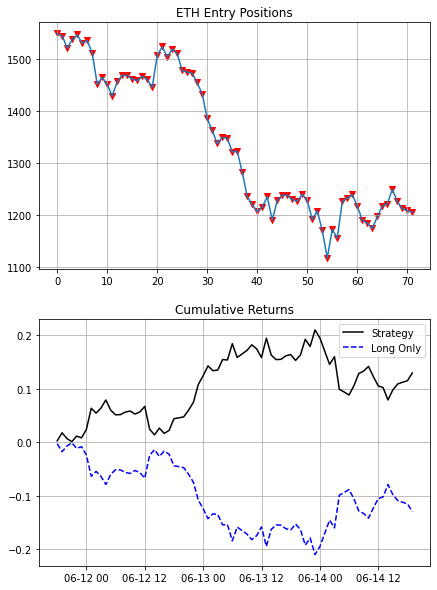

In [104]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import NMF
sc_X = MinMaxScaler()

def Model_plot_NMF(AllData, Periods, oos_prop, span, C, gamma):
  Periods = int(Periods)
  X_train, X_test, y_train, y_test, oos_X, oos_y_target, oos_y_WasUp, oos_close = SpitOutWasUp(AllData, Periods, 72, oos_prop)

  from sklearn.preprocessing import MinMaxScaler
  sc_X = MinMaxScaler()

  X_train_sc = sc_X.fit_transform(X_train)
  X_test_sc = sc_X.fit_transform(X_test)
  oos_X_sc = sc_X.fit_transform(oos_X)

  model2 = NMF(n_components=5)

  X_train_sc = model2.fit_transform(X_train_sc)
  X_test_sc = model2.transform(X_test_sc)
  oos_X_sc = model2.transform(oos_X_sc)

  model = SVC(kernel='rbf', C=C, gamma=gamma, random_state=42, probability=True)
  model.fit(X_train_sc, y_train)

  # Train Acc
  preds = model.predict(X_train_sc)
  trainacc = accuracy_score(y_train, preds)
  # Test Acc
  preds = model.predict(X_test_sc)
  testacc = accuracy_score(y_test, preds)
  # OOS Acc
  preds_oos = model.predict(oos_X_sc)
  acc_oos = accuracy_score(oos_y_target, preds_oos)
  # OOS Preds
  predProb = model.predict_proba(oos_X_sc)
  predProb = predProb[:, 1]
  longOnly = copy.deepcopy(oos_y_WasUp)
  span = span
  for i in range(len(oos_y_WasUp)):
    if predProb[i] < .5 - span:
      oos_y_WasUp[i] = -oos_y_WasUp[i]
    elif predProb[i] >= .5 + span:
      oos_y_WasUp[i] = oos_y_WasUp[i]
    else:
      oos_y_WasUp[i] = 0

  d = {'TrainAccuracy': [trainacc],
       'testacc': [testacc],
       'OOSAccuracy': [acc_oos],
       'TotalRets': [sum(oos_y_WasUp/Periods)],
       'PercLong': [len(predProb[predProb>.5])/len(predProb)],
       'AvgLong': [np.mean(oos_y_WasUp[predProb>.5])],
       'StdLong': [np.std(oos_y_WasUp[predProb>.5])],
       'AvgShort': [np.mean(oos_y_WasUp[predProb <=.5])],
       'StdShort': [np.std(oos_y_WasUp[predProb <=.5])],
       'C': [C],
       'gamma': [gamma],
       'periods': [Periods],
       'span': [span]}
  fig,axs = plt.subplots(2,1,figsize=(7,10))
  axs[0].plot(oos_close.values)
  print(len(predProb),len(oos_close))
  for i in range(len(oos_close)):
    if predProb[i] >= .5 + span:
      axs[0].scatter(i, oos_close.values[i]*0.9995,color='g',marker='^')
    elif predProb[i] < .5 - span:
      axs[0].scatter(i, oos_close.values[i]*1.0005, color='r',marker='v')
  axs[0].grid()
  axs[0].set_title('ETH Entry Positions')

  axs[1].plot(np.cumsum(oos_y_WasUp/Periods),'-k')
  axs[1].plot(np.cumsum(longOnly),'--b')
  axs[1].grid()
  axs[1].legend(['Strategy','Long Only'])
  axs[1].set_title('Cumulative Returns')

  return d


d = Model_plot_NMF(AllData,
           Periods = 1,
           oos_prop=.8,
           span= 0.0,
           C=d2['C'][0],
           gamma= d2['gamma'][0])
print(d)

#### Model Comparison and Discussion

On the surface, the two models look fairly similar. Both outperform the standard Long only strategy of buy and hold Ethereum.
When Scrutinized a bit further, you can see that the model that takes PCA compressed features, as an input as opposed to the base features,
 has a higher Out of sample total return. NMF compression performs best, but it appears the model is mostly predicting 'short' positions
 which have done well during the recent market sell off. It is unclear if the model is predominately a short-market model.

Base features:
- 58.3% Out of sample accuracy
- 8.7% total return


PCA features:
- 63.38% Out of sample accuracy
- 12.97% total return

NMF features:
- 61.1%
-  12.9% total return

The three models outperformed the baseline case of strictly holding Ethereum which resulted in a 12.5% loss of funds.

##### Discussion

This work only begins to scratch the surface of developing optimal trading straegies based off of compressed features.
Additional optimization exercises in other compression algorithms such as Nonzero matrix factorialization may offer incremental improvements in efficency and profitability.
A more formal investigation into optimal component usage may also yield insight. Lastly, this notebook specifically utilized SVM algorithms; however, other methodologies
such as neural networks and logistic regression were not considered.

In [ ]:
# Sources:

# SKlearn NMF
# https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py
# SKlean PCA
# https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

